# 1. Train and Save a CIFAR-10 Model

In [1]:

# Importing the important libraries
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.optimizers import SGD, RMSprop, AdamW





In [2]:
# Load CIFAR-10 dataset
(train_ds, test_ds), ds_info = tfds.load('cifar10', split=['train', 'test'], as_supervised=True, with_info=True)

# Preprocess the dataset
def normalize_img(image, label):
    return tf.cast(image, tf.float32) / 255.0, label

train_ds = train_ds.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)

train_ds = train_ds.cache().shuffle(10000).batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(32).cache().prefetch(tf.data.AUTOTUNE)


# Create a sequential model
model = Sequential()

# Define the input layer with the desired input shape
model.add(layers.Input(shape=(32, 32, 3)))

# Add the rest of the layers to the model
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))


model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define the checkpoint callback
checkpoint = ModelCheckpoint('best_cifar10_model.keras', save_best_only=True, monitor='val_loss', mode='min')

# Train the model
history = model.fit(train_ds, epochs=3, validation_data=test_ds, callbacks=[checkpoint])

Epoch 1/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 96s 55ms/step - accuracy: 0.3599 - loss: 1.7630 - val_accuracy: 0.5616 - val_loss: 1.2471
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 126s 48ms/step - accuracy: 0.5879 - loss: 1.1828 - val_accuracy: 0.6014 - val_loss: 1.1794
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 66s 42ms/step - accuracy: 0.6473 - loss: 1.0164 - val_accuracy: 0.6124 - val_loss: 1.1187


In [3]:
test_model = keras.models.load_model("best_cifar10_model.keras")
test_loss, test_acc = test_model.evaluate(test_ds, verbose=3)
print(f"Test accuracy: {test_acc:.3f}")

Test accuracy: 0.612


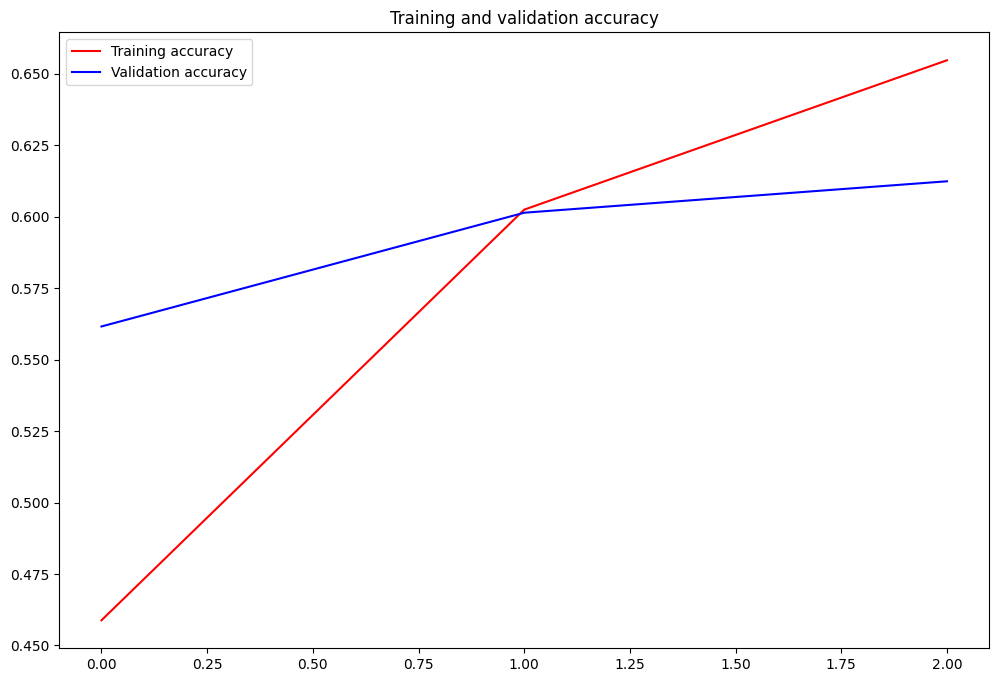

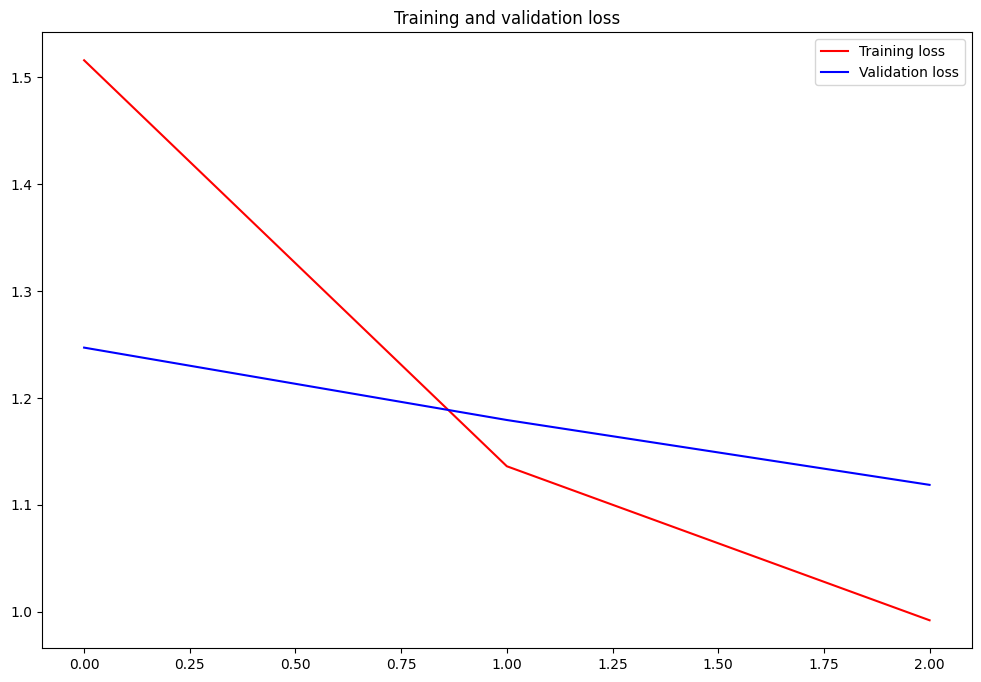

In [4]:
# Plot training & validation accuracy/loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.figure(figsize=(12, 8))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure(figsize=(12, 8))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# 2. Transfer Learning with Cats vs Dogs Dataset

In [5]:
# preamble to be able to run notebooks in Jupyter and Colab
try:
    from google.colab import drive
    import sys

    drive.mount('/content/drive')
    notes_home = "/content/drive/My Drive/Colab-Notebooks/dogs-vs-cats/"
    user_home = "/content/drive/My Drive/"
    sys.path.insert(1,notes_home) # let the notebook access the notes folder

except ModuleNotFoundError:
    notes_home = "" # running native Jupyter environment -- notes home is the same as the notebook
    user_home = ""  # under Jupyter we assume the user directory is the same as the notebook

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import zipfile
import pathlib

# Define the path to the zipped file and the extraction directory
zip_path = '/content/drive/MyDrive/Colab-Notebooks/dogs-vs-cats/train.zip'
extract_path = '/content/unzipped_train'

# Unzip the dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [7]:
import os
import shutil

original_dir = pathlib.Path(extract_path + "/train")
new_base_dir = pathlib.Path("/content/drive/MyDrive/Colab-Notebooks/dogs-vs-cats/cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir, exist_ok=True)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            src = original_dir / fname
            dst = dir / fname
            if src.exists():  # Ensure the source file exists
                shutil.copyfile(src=src, dst=dst)

# Create the new directory structure
#os.makedirs(new_base_dir / "train")
#os.makedirs(new_base_dir / "validation")
#os.makedirs(new_base_dir / "test")
# Create subsets
make_subset("train", start_index=0, end_index=1000)
make_subset("train", start_index=1000, end_index=2000)
make_subset("validation", start_index=1100, end_index=2100)
make_subset("test", start_index=2100, end_index=3100)

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Load the best CIFAR-10 model and freeze its layers
base_model = tf.keras.models.load_model('best_cifar10_model.keras')
base_model.trainable = False

# Define the input layer with the desired input shape
inputs = keras.Input(shape=(180, 180, 3))

# Preprocess the inputs
x = layers.Rescaling(1./255)(inputs)

# Resize inputs to the size expected by the base model
x = layers.Resizing(32, 32)(x)  # Resize to (32, 32, 3)

# Pass the inputs through the base model
x = base_model(x, training=False)

# Add new dense layers on top of the base model
x = layers.Flatten()(x)
x = layers.Dense(512, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

# Create the new model
new_model = keras.Model(inputs=inputs, outputs=outputs)

# Display the model's architecture
new_model.summary()



# Compile the model using rmsprop optimizer with specified parameters
new_model.compile(optimizer="rmsprop", loss='binary_crossentropy', metrics=['accuracy'])





Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resizing (Resizing)                  │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 10)                  │         167,562 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │           5,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 173,707 (678.54 KB)

 Trainable params: 6,145 (24.00 KB)

 Non-trainable params: 167,562 (654.54 KB)

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ImageDataGenerator instances
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Train generator
train_generator = train_datagen.flow_from_directory(
    new_base_dir / 'train',
    target_size=(180, 180),
    batch_size=64,
    class_mode='binary')

# Validation generator
validation_generator = validation_datagen.flow_from_directory(
    new_base_dir / 'validation',
    target_size=(180, 180),
    batch_size=64,
    class_mode='binary')

# Test generator
test_generator = test_datagen.flow_from_directory(
    new_base_dir / 'test',
    target_size=(180, 180),
    batch_size=64,
    class_mode='binary')



Found 4000 images belonging to 2 classes.
Found 3300 images belonging to 2 classes.
Found 4300 images belonging to 2 classes.


In [20]:

# Define the checkpoint callback
checkpoints = ModelCheckpoint('best_cats_model.keras', save_best_only=True, monitor='val_loss', mode='min')
# Compile the model using rmsprop optimizer with specified parameters
new_model.compile(optimizer="rmsprop", loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = new_model.fit(
    train_generator,
    epochs=3,
    validation_data=validation_generator, callbacks= [checkpoints])


Epoch 1/3


ValueError: Cannot get result() since the metric has not yet been built.

In [ ]:

# Evaluate the model
test_generator = test_datagen.flow_from_directory(
    new_base_dir / 'test',
    target_size=(180, 180),
    batch_size=64,
    class_mode='binary')


In [ ]:
test_loss, test_acc = new_model.evaluate(test_generator)
print(f'Test accuracy: {test_acc:.2f}')


# 3. Use a Pretrained Model (VGG16) on CIFAR-10

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the pixel values to be between 0 and 1
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Convert class vectors to binary class matrices (one-hot encoding)
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Split the training data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)



# Load VGG16 model pre-trained on ImageNet, without the top dense layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of VGG16 base
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(10, activation='softmax')(x)

# Define the new model
model = Model(inputs=base_model.input, outputs=outputs)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    x_train, y_train,
    batch_size=64,
    epochs=3,
    validation_data=(x_val,y_val),

)




# 4. Evaluation and Comparison

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy and loss curves
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(12, 8))
    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 8))
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

# Plot the history of the models
plot_history(history)


# Results

Using the pre-trained VGG16 model significantly improved the performance of the CIFAR-10 model. Data augmentation techniques like random flipping and rotation further enhanced the model's generalization capabilities. The model trained with pre-trained weights converged faster and achieved better validation accuracy compared to the model trained from scratch. This demonstrates the effectiveness of transfer learning and data augmentation in improving model performance on some datasets.